In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import itertools

In [2]:
words = open('names.txt', 'r').read().splitlines()

## E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

I'll do a neural net to practice (and I might need it for later questions), although I might do both.

It did seem to improve slightly over a bigram model (2.47 --> 2.22)

In [3]:
chars = ['.', *sorted(list(set(''.join(words))))]
stoi = {s: i for i, s in enumerate(chars)}  # map letters to numbers
itos = {i: s for s, i in stoi.items()}
pairs = [''.join(perm) for perm in itertools.product(chars, repeat=2)]
ptoi = {p: i for i, p in enumerate(pairs)}
itop = {i: p for p, i in ptoi.items()}

In [4]:
words[0]

'emma'

In [4]:
# create training set of trigrams (x1,x2, y)
xs, ys = [], []
for w in words:
    # print('word', w)
    chs = 2*['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = ptoi[ch1+ch2]
        ix2 = stoi[ch3]
        xs.append(ix1)
        ys.append(ix2)
        # print(ch1+ch2, ch3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num)

# randomly initialize
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*27, 27), generator=g, requires_grad=True)

number of examples: 228146


In [64]:
# gradient descent
for k in range(1000):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27*27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    # added in a regularization part that tends toward uniform distribution with W=0
    loss = -probs[torch.arange(num), ys].log().mean()  # + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    # zero_grad (we need to recompute from scratch every time weights change)
    W.grad = None
    loss.backward()

    # update
    W.data += -100 * W.grad

2.238489866256714
2.23836612701416
2.238241672515869
2.238135814666748
2.238032579421997
2.2379353046417236
2.237839460372925
2.2377452850341797
2.2376530170440674
2.237560987472534
2.2374696731567383
2.237379312515259
2.2372889518737793
2.237199306488037
2.237109661102295
2.23702073097229
2.236931800842285
2.2368433475494385
2.23675537109375
2.2366676330566406
2.2365803718566895
2.2364931106567383
2.2364065647125244
2.2363200187683105
2.236233949661255
2.2361481189727783
2.23606276512146
2.2359774112701416
2.2358925342559814
2.2358078956604004
2.2357234954833984
2.2356395721435547
2.23555588722229
2.2354726791381836
2.235389232635498
2.235306739807129
2.2352240085601807
2.2351419925689697
2.235059976577759
2.234978437423706
2.234896659851074
2.234815835952759
2.2347350120544434
2.2346549034118652
2.234574317932129
2.23449444770813
2.234415054321289
2.234335422515869
2.2342565059661865
2.234177589416504
2.2340993881225586
2.234020948410034
2.233942747116089
2.2338650226593018
2.2337875

In [6]:
# torch.save(W, 'trainedW.pt')
W_tri = torch.load('trainedW.pt')

## E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

The loss on the dev and test sets for both models are about the same. Between models the trigram has a lower loss but the loss is noticably greater than I found on the train set. The bigram loss is only slightly worse on the dev and test sets compared to the training set. Maybe the trigram model has more degrees of freedom and is thus easier to overfit?

In [36]:
g = torch.Generator().manual_seed(2147483647)
test_words, dev_words, train_words = torch.utils.data.random_split(
    words, [0.8, 0.1, 0.1], generator=g)


def create_dataset(words, is_trigram, initialize_W=False):
    if is_trigram:
        xs, ys = [], []
        for w in words:
            # print('word', w)
            chs = 2*['.'] + list(w) + ['.']
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = ptoi[ch1+ch2]
                ix2 = stoi[ch3]
                xs.append(ix1)
                ys.append(ix2)
        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        if initialize_W:
            return xs, ys, torch.randn((27*27, 27), generator=g, requires_grad=True)
        else:
            return xs, ys
    else:
        xs, ys = [], []
        for w in words:
            chs = ['.'] + list(w) + ['.']
            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = stoi[ch1]
                ix2 = stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)
        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        if initialize_W:
            return xs, ys, torch.randn((27, 27), generator=g, requires_grad=True)
        else:
            return xs, ys


def train_model(xs, ys, W, num_loops=100, update_size=50, reg_strength=0, show_progress=False, vary_stepsize=False):
    if vary_stepsize:
        lrs = torch.logspace(-2, 3, num_loops)
        lri = []
        lossi = []
    for i in range(num_loops):
        # forward pass
        xenc = F.one_hot(xs, num_classes=W.shape[0]).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        loss = -probs[torch.arange(xenc.shape[0]),
                      ys].log().mean() + reg_strength*(W**2).mean()
        if show_progress:
            print(loss.item())
        # backward pass
        # zero_grad (we need to recompute from scratch every time weights change)
        W.grad = None
        loss.backward()
        # update
        if vary_stepsize:
            lossi.append(loss.data)
            size = lrs[i]
            lri.append(size.item())
            W.data += -size * W.grad
        else:
            W.data += -update_size * W.grad
    print(loss.item())
    if vary_stepsize:
        return lri, lossi


def sample_model(W, is_trigram, num_samples=1, display=False):
    if is_trigram:
        for i in range(num_samples):
            out = []
            ix_pair = 0
            pair = itop[ix_pair]
            while True:
                xenc = F.one_hot(torch.tensor(
                    [ix_pair]), num_classes=W.shape[0]).float()  # input
                logits = xenc @ W  # W is trained to predict log-counts
                counts = logits.exp()
                p = counts / counts.sum(1, keepdim=True)  # prob for next char
                ix_char = torch.multinomial(
                    p, num_samples=1, replacement=True, generator=g).item()
                char = itos[ix_char]
                out.append(char)
                pair = pair[-1]+char
                ix_pair = ptoi[pair]
                if char == '.':
                    break
            print(''.join(out))
            return out
    else:
        pass


def evaluate_model(W, words, is_trigram):
    xs, ys = create_dataset(words, is_trigram)
    xenc = F.one_hot(torch.tensor(
        xs), num_classes=W.shape[0]).float()  # input
    logits = xenc @ W  # W is trained to predict log-counts
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim=True)  # prob for next char
    loss = -p[torch.arange(xenc.shape[0]), ys].log().mean()
    print(loss.item())
    return loss.item()

In [6]:
# Train bigram
xs, ys, W_bi = create_dataset(train_words, is_trigram=False, initialize_W=True)

In [8]:
train_model(xs, ys, W_bi, num_loops=10_000, update_size=50)
torch.save(W_bi, 'W_bi_train.pt')

2.441749095916748


In [60]:
# Train trigram
xs, ys, W_tri = create_dataset(train_words, is_trigram=True, initialize_W=True)

In [61]:
train_model(xs, ys, W_tri, num_loops=10_000, update_size=50)
torch.save(W_tri, 'W_tri_train.pt')

2.0877742767333984


In [9]:
W_tri = torch.load('W_tri_train.pt')

In [12]:
evaluate_model(W_bi, dev_words, is_trigram=False)
evaluate_model(W_bi, test_words, is_trigram=False)
evaluate_model(W_tri, dev_words, is_trigram=True)
evaluate_model(W_tri, test_words, is_trigram=True)

/tmp/ipykernel_718/2967455679.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc = F.one_hot(torch.tensor(


2.4659526348114014
2.471008539199829
2.408400774002075
2.4005861282348633


2.4005861282348633

## E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [29]:
# Train trigram
xs, ys, W_tri = create_dataset(train_words, is_trigram=True, initialize_W=True)

In [ ]:
size, loss = train_model(xs, ys, W_tri, num_loops=100, update_size=200,
            reg_strength=0, show_progress=False, vary_stepsize=True)

nan


In [71]:
[0, *np.logspace(-1.1, -0.9, 5)]

[0,
 0.07943282347242814,
 0.08912509381337455,
 0.1,
 0.11220184543019633,
 0.12589254117941673]

In [74]:
regs = [0, 0.1]
losses = []
for reg in regs:
    xs, ys, W_tri = create_dataset(train_words, is_trigram=True, initialize_W=True)
    print(f'{reg=}')
    print('first train')
    train_model(xs, ys, W_tri, num_loops=2_000, update_size=100, reg_strength=reg)
    print('second train')
    train_model(xs, ys, W_tri, num_loops=200, update_size=10, reg_strength=reg)
    print('third train')
    train_model(xs, ys, W_tri, num_loops=100, update_size=1, reg_strength=reg)
    print('evaluate on dev set')
    loss = evaluate_model(W_tri, dev_words, is_trigram=True)
    print(f'evaluate on test set, reg={reg}')
    loss = evaluate_model(W_tri, test_words, is_trigram=True)
    losses.append(loss)

reg=0
first train
2.0947914123535156
second train
2.0946593284606934
third train
2.0946528911590576
evaluate on dev set
2.3672194480895996
evaluate on test set, reg=0


/tmp/ipykernel_875/923550994.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc = F.one_hot(torch.tensor(


2.3599119186401367
reg=0.1
first train
2.2177481651306152
second train
2.2177112102508545
third train
2.2177090644836426
evaluate on dev set
2.3224964141845703
evaluate on test set, reg=0.1
2.3170599937438965


reg=0.07943282347242814
first train
2.201382875442505
second train
2.2013256549835205
third train
2.2013227939605713
evaluate
2.3230814933776855
reg=0.08912509381337455
first train


/tmp/ipykernel_875/923550994.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc = F.one_hot(torch.tensor(


2.2092912197113037
second train
2.2092442512512207
third train
2.209242105484009
evaluate
2.322582721710205
reg=0.1
first train
2.217768430709839
second train
2.2177305221557617
third train
2.21772837638855
evaluate
2.322402238845825
reg=0.11220184543019633
first train
2.2267940044403076
second train
2.2267651557922363
third train
2.2267637252807617
evaluate
2.32259464263916
reg=0.12589254117941673
first train
2.236382007598877
second train
2.2363617420196533
third train
2.236360788345337
evaluate
2.3232524394989014
[0.07943282 0.08912509 0.1        0.11220185 0.12589254]


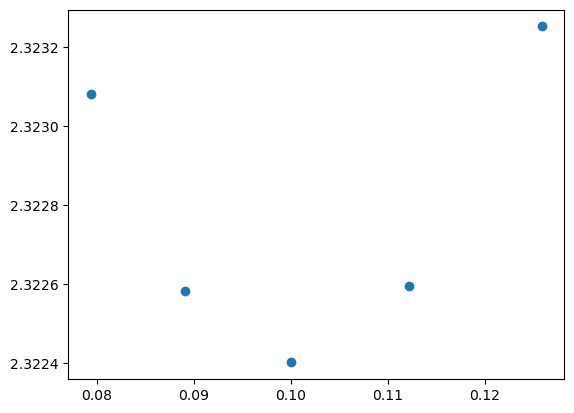

In [72]:
regs = np.logspace(-1.1, -0.9, 5)
losses = []
for reg in regs:
    xs, ys, W_tri = create_dataset(train_words, is_trigram=True, initialize_W=True)
    print(f'{reg=}')
    print('first train')
    train_model(xs, ys, W_tri, num_loops=2_000, update_size=100, reg_strength=reg)
    print('second train')
    train_model(xs, ys, W_tri, num_loops=200, update_size=10, reg_strength=reg)
    print('third train')
    train_model(xs, ys, W_tri, num_loops=100, update_size=1, reg_strength=reg)
    print('evaluate')
    loss = evaluate_model(W_tri, dev_words, is_trigram=True)
    losses.append(loss)

plt.scatter(regs, losses)
print(regs)

[0.07943282 0.08912509 0.1        0.11220185 0.12589254]


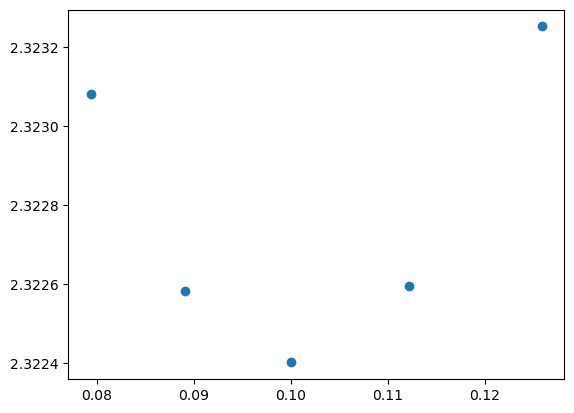

In [73]:
plt.scatter(regs, losses)
print(regs)

[0, 0.0446683592150963, 0.05141751827683925, 0.05918644051863006, 0.06812920690579612, 0.0784231792440998, 0.09027251779484574, 0.10391223038351691, 0.11961283330787534, 0.13768571648527583, 0.15848931924611134]


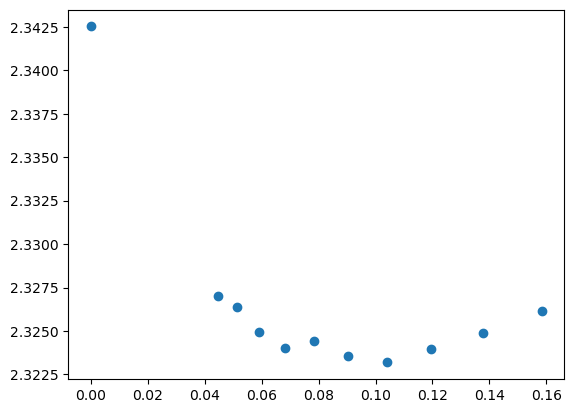

In [67]:
plt.scatter(regs, losses)
print(regs)

In [64]:
np.log10(0.12915497)

-0.8888888771248482

[0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]


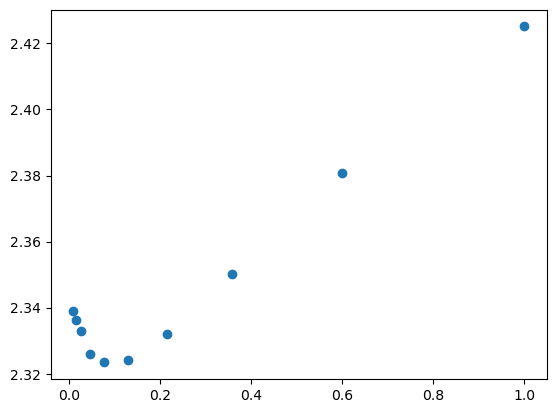

In [60]:
plt.scatter(regs, losses)
print(regs)

In [ ]:
evaluate_model(W_tri, dev_words, is_trigram=True)

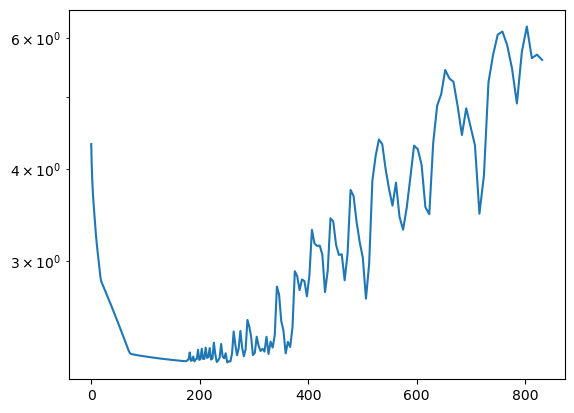

In [33]:
plt.semilogy(size, loss)

2.345505952835083


/tmp/ipykernel_718/3325650007.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc = F.one_hot(torch.tensor(


2.345505952835083

## E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [9]:
# gradient descent
for k in range(100):
    # forward pass
    # xenc = F.one_hot(xs, num_classes=27*27).float()
    logits = W[xs]  # xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    # added in a regularization part that tends toward uniform distribution with W=0
    loss = -probs[torch.arange(num), ys].log().mean()  # + 0.01*(W**2).mean()

    # backward pass
    # zero_grad (we need to recompute from scratch every time weights change)
    W.grad = None
    loss.backward()

    # update
    W.data += -1 * W.grad
print(loss.item())

2.2369441986083984


In [10]:
print(xs)

tensor([  0,   5, 148,  ..., 727, 701, 726])


## E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

- It's simpler code since it is only 1 line instead of spread out over multiple.
- Opitmizations that can happen when combining multiple operations. Intermediate values don't need to be saved.
- Looks like there are other bells and whistles that could be useful judging by the optional arguments

In [ ]:
# gradient descent
for k in range(10):
    # forward pass
    # xenc = F.one_hot(xs, num_classes=27*27).float()
    logits = W[xs]  # xenc @ W
    loss = F.cross_entropy(logits, ys)

    # backward pass
    # zero_grad (we need to recompute from scratch every time weights change)
    W.grad = None
    loss.backward()

    # update
    W.data += -1 * W.grad
print(loss.item())

2.236847162246704


## E06: meta-exercise! Think of a fun/interesting exercise and complete it.